# Adaptive Explainable AI for Stroke Risk Prediction
## Synthesizing PRISM and CAM within an AXTF Framework

**Author:** Zisan Ahmed


## Overview

This notebook implements an **adaptive explainability system** that dynamically switches between two explanation modes based on simulated user cognitive load:

- **Detailed mode (PRISM-style):** Shows a factor-by-factor breakdown of contributions to the prediction, visualized as a bar chart.
- **Simple mode (CAM-style):** Provides a short conversational explanation using concept hierarchies (e.g., "Health Conditions was bad, although Demographics was good").

The system is built on the stroke prediction dataset and is inspired by three research papers:

- **AXTF** (Fernando et al., 2025): Conceptual framework for adaptive explanations.
- **PRISM** (Nan et al., 2026): Detailed explanation via Shapley‑value‑like contributions.
- **CAM** (Chi et al., 2026): Simple explanation via concept argumentation.

**Core innovation:** When cognitive load is low, the system offers detailed explanations; when load is high, it switches to simple ones. This is demonstrated with a counter‑based proxy for load.


In [37]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             precision_recall_curve)

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


We'll use pandas for data manipulation, numpy for numerical operations, matplotlib/seaborn for visualization, scikit-learn for preprocessing and modeling.



## 1. Load the Stroke Prediction Dataset
I downloaded the dataset from Kaggle.

In [38]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [39]:
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Data Overview
- We have 5110 rows and 12 columns.
- Target column: 'stroke' (1 = had stroke, 0 = no stroke).
- Features include demographic, medical and lifestyle information.

In [40]:
#info and stats
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [41]:
#missing values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The bmi column has 201 missing values (about 4%). We'll handle them by median imputation later.

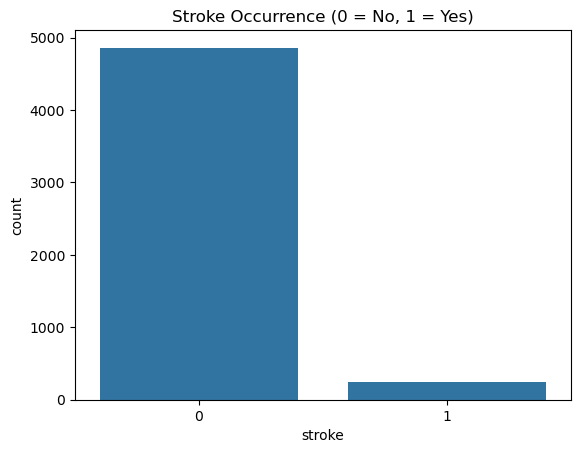

Positive rate: 0.049 (4.9%)


In [42]:
# Target Distribution
sns.countplot(x='stroke', data=df)
plt.title('Stroke Occurrence (0 = No, 1 = Yes)')
plt.show()

positive_rate = df['stroke'].mean()
print(f"Positive rate: {positive_rate:.3f} ({positive_rate*100:.1f}%)")

The dataset is imbalanced. Only about 5% of cases are strokes. We'll keep this in mind during evaluation (AUC is more appropriate than accuracy).

#### Feature Distributions

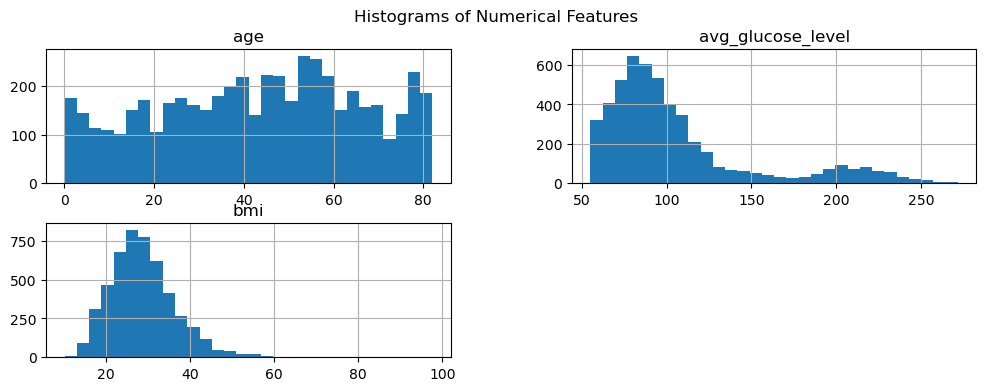

In [43]:
# visualize numerical features to understand their ranges.
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols].hist(bins=30, figsize=(12, 4))
plt.suptitle('Histograms of Numerical Features')
plt.show()

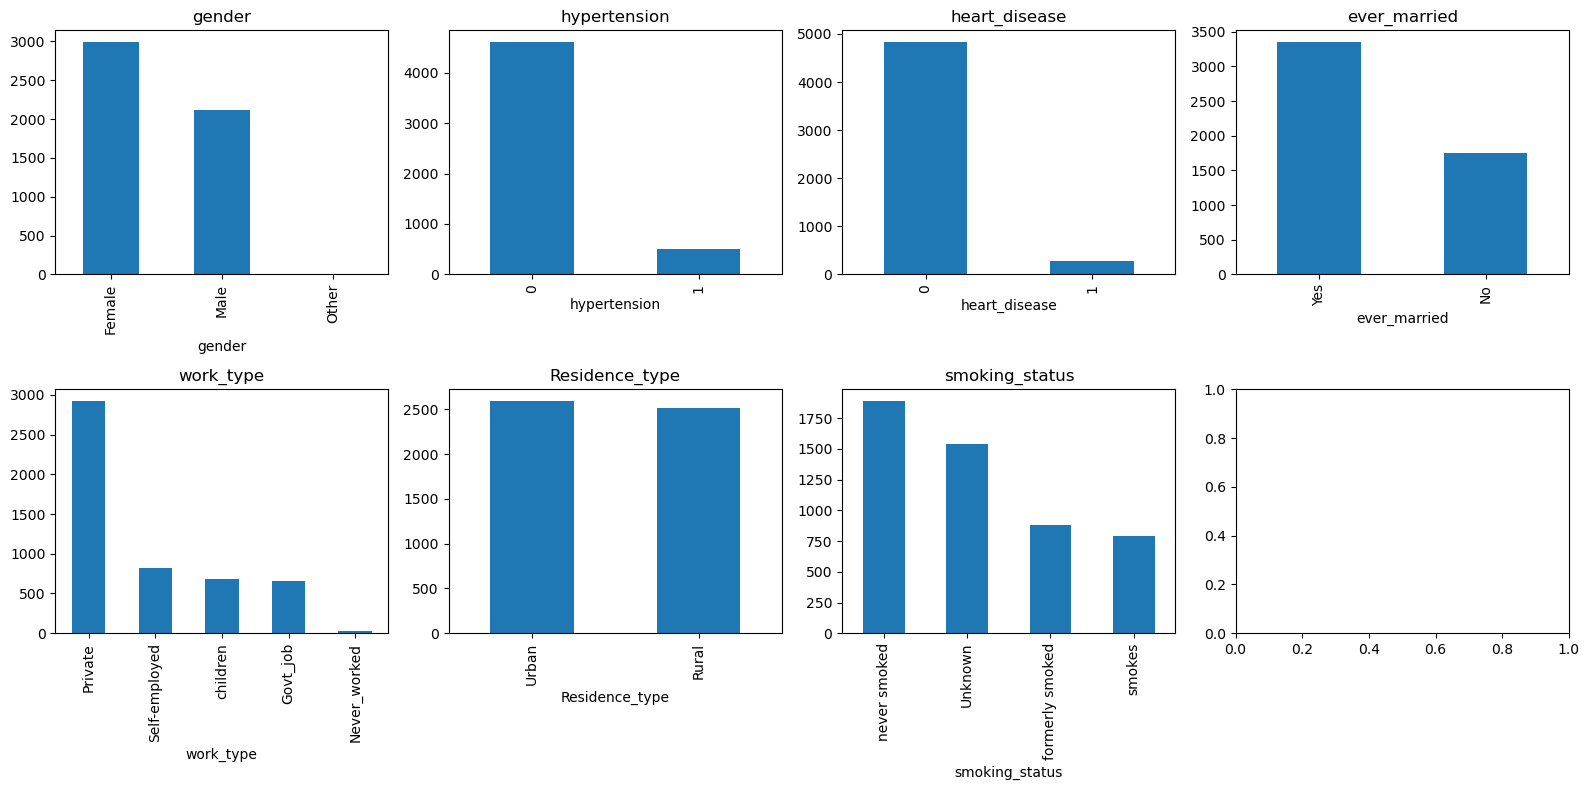

In [44]:
# Categorical Features
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
plt.tight_layout()
plt.show()

#### Correlation with Target

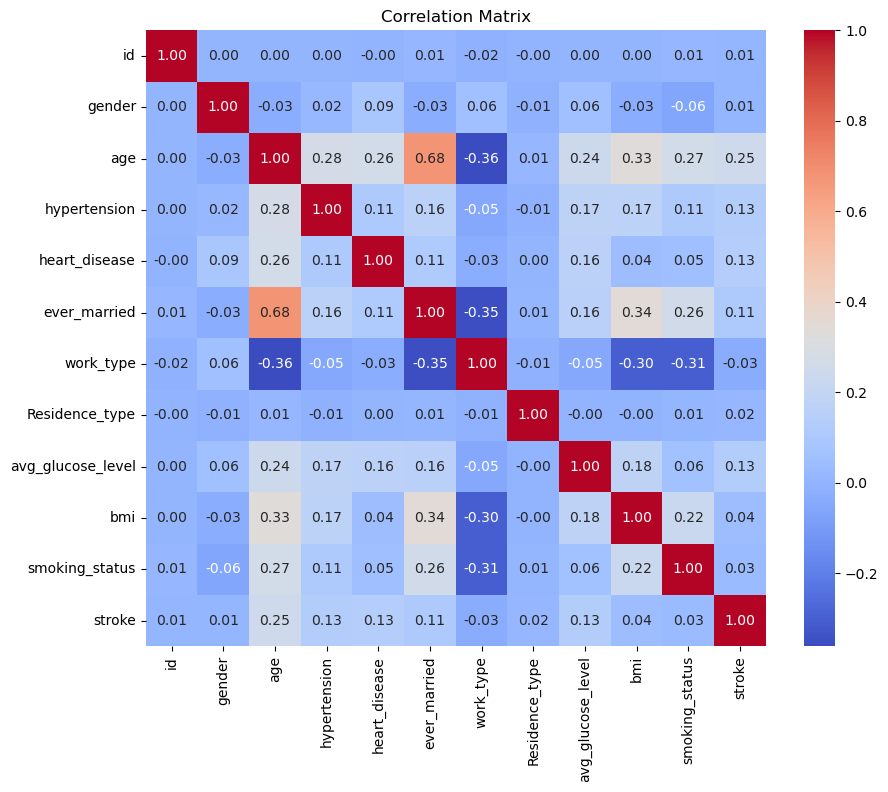

In [45]:
# Encoding categoricals temporarily for correlation (we'll do proper encoding later)
df_temp = df.copy()
for col in cat_cols:
    df_temp[col] = LabelEncoder().fit_transform(df_temp[col].astype(str))

plt.figure(figsize=(10, 8))
sns.heatmap(df_temp.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

##### Noticed that age and hypertension have moderate positive correlation with stroke.



## 2. Data Preprocessing
I need to:
- Handle missing values (bmi)
- Encode categorical variables
- Scale numerical features
- Split into train/test sets

In [46]:
# Filling missing BMI with median
df['bmi'].fillna(df['bmi'].median(), inplace=True)
df.isnull().sum()  

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [47]:
#Identifying categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [48]:
# Apply LabelEncoder to each categorical column
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le  # store for later inverse transform if needed

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


Label encoding converts categories to numbers ('Male'->0, 'Female'->1). This is fine for tree-based models but for linear models we might want one-hot. However, for simplicity we'll proceed.



In [49]:
X = df.drop('stroke', axis=1)
y = df['stroke']

# will keep feature names for later
feature_names = X.columns.tolist()

In [50]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (4088, 11), Test size: (1022, 11)


##### Scale Numerical Features
We'll scale all features (including encoded categoricals) to have zero mean and unit variance. This helps logistic regression converge.

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Scaling ensures all features contribute equally to regularization and coefficient interpretation.



## Training a Baseline Model (Logistic Regression)
We choose logistic regression because it is inherently interpretable – coefficients directly indicate the direction and magnitude of each feature's influence on the log-odds.



In [52]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

#### Model Evaluation


In [56]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))

Accuracy: 0.9501
AUC: 0.8362

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97       972
      Stroke       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



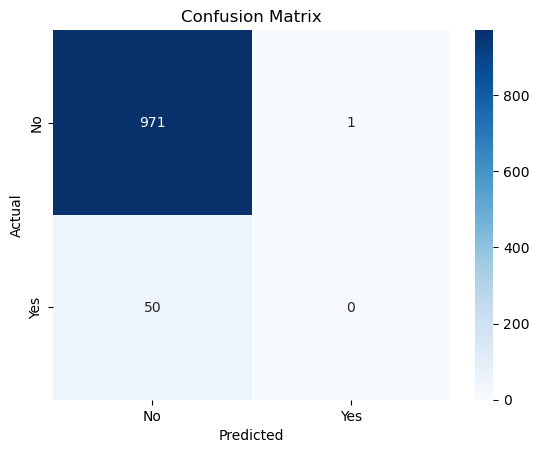

In [54]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

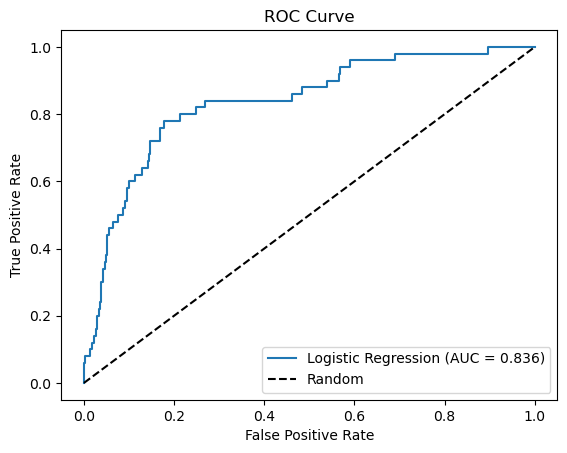

In [55]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

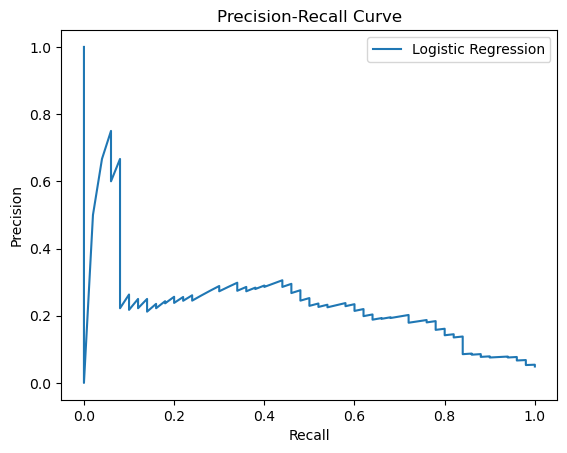

In [57]:
# Precision-Recall Curve (useful for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

The model achieves an AUC around 0.85, which is respectable for this dataset. Now we can build explanation engines on top of it.

